In [2]:
try:
    import pymc as pm
except:
    %pip install pymc==5.8.0    
    import pymc as pm
    
print(pm.__version__)

%pip install --force-reinstall --no-deps git+https://github.com/pymc-devs/pymc-bart.git@main
#try:
import pymc_bart as pmb
#except:
#    %pip install pymc-bart
#    import pymc_bart as pmb
    

print(pmb.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import pickle

import boto3
from sagemaker import get_execution_role
import xgboost

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.8.0
  Cloning https://github.com/pymc-devs/pymc-bart.git (to revision main) to /tmp/pip-req-build-jiyqu3lr
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-devs/pymc-bart.git /tmp/pip-req-build-jiyqu3lr
  Resolved https://github.com/pymc-devs/pymc-bart.git to commit 709d3c4d08d5e17740db25e52b66c6e0846879c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymc-bart: filename=pymc_bart-0.5.1-py3-none-any.whl size=32982 sha256=c2fad375a9c61995f24889b3a79b93afb47e4323b789564f4b209ab84a3797cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-4s5hwh_l/wheels/dd/bb/fa/be5eab50aea9b866e2b73d658b13b91fe445e12c4a1a18fe7a
Successfully built pymc-bart
  Attempting uninstall: pymc-bart
    Found existing installation: pymc-bart 0.5.1
    Uninstalling pymc-bart-0.5.1:
      Successfully uninstalled pymc-bart-0.5.1

[notice] A new release of pip is available: 23.1.

In [3]:
# configure training/testing environment
DKU_DST_ap_data_sector = 'SOY_NA_SUMMER'
DKU_DST_analysis_type = 'SingleExp'

tune = 10
draws = 50
chains= 1
n_trees =  20

train_yrs = [2020,2021]
test_yr = 2022

tree_fname = 'BART_real_data_forest_20trees_50draws_1chains_fewtraits.pkl' # filename
data_fname = 'BART_real_test_data_fewtraits.pkl'

load_data_from_s3 = 0 # otherwise load saved data
train_bart_model = 1
save_bart_model = 1 # otherwise load model

# useful functions
def get_predictions_from_trees(forests, x_te):
    # sample from each forest in forests
    # forests is a list of a list.
    # the outer list contains each forest
    # each forest contains trees. Average predictions from each tree in a forest, output each forest prediction
    # output is x_te.shape[0] x N_forests
    
    pred_out = np.zeros((x_te.shape[0], len(forests)))
    for i_forest in range(len(forests)):
        trees = forests[i_forest]
        temp_pred = 0
        for tree in trees:
            temp_pred += tree.predict(x_te)
        pred_out[:,i_forest] = temp_pred
    return pred_out

def invlogit(x):
    return 1/(1+np.exp(-x))

def sample_posterior(forests, x_te):
    forest_pred = get_predictions_from_trees(forests,x_te)
    return invlogit(forest_pred)

In [4]:
if load_data_from_s3:
    # read inputs
    # code below is to get data from s3 bucket...?
    role = get_execution_role() # not necessary
    region = boto3.Session().region_name # not necessary
    bucket='us.com.syngenta.ap.nonprod' # Replace with your s3 bucket name

    df_all_melt = pd.DataFrame()
    for yr in ['2020','2021','2022']:
        fpath = 'uat/dme/performance/compute_pred_adv_data_collected/data/SOY_NA_SUMMER/SingleExp/{}'.format(yr) # fpath within bucket
        fname = 'pred_adv_data_collected.csv' # filename
        data_location = 's3://{}/{}/{}'.format(bucket,fpath,fname)
        df_temp = pd.read_csv(data_location)
        df_all_melt = pd.concat((df_all_melt,df_temp),axis=0)

    # pivot table, get appropriate stage
    # set index columns previously used to melt data
    melt_cols = ['ap_data_sector','analysis_year','entry_identifier',\
                 'material_type','decision_group_rm','technology','trait','var']

    #if DKU_DST_ap_data_sector == 'SOY_NA_SUMMER':
        #melt_cols.remove('source_id')

    melt_no_stack_cols = melt_cols.copy()
    melt_no_stack_cols.remove('trait')
    melt_no_stack_cols.remove('var')

    # set some inputs and clean up some columns
    if DKU_DST_ap_data_sector == 'CORN_NA_SUMMER' or DKU_DST_ap_data_sector == 'SOY_NA_SUMMER':
        yield_trait = 'YGSMN'
    elif DKU_DST_ap_data_sector == 'CORN_EAME_SUMMER':
        yield_trait = 'YSDMN'

    df_all_melt['technology'] = df_all_melt['technology'].fillna(value='conv')

    # update type of some cols
    float_cols = ['stage','decision_group_rm']
    for col in float_cols:
        df_all_melt[col] = df_all_melt[col].astype(float)

    # replace Nan's for some cols
    df_all_melt['trait'][df_all_melt['trait'].isna()] = ''
    #df_all_melt['decision_group'][df_all_melt['decision_group'].isna()] = 'na'
    df_all_melt[melt_no_stack_cols] = df_all_melt[melt_no_stack_cols].fillna(value=-1045)


    # fix strings to other tpyes
    for as_str, as_bool in zip(['False','True'],[0, 1]):
        df_all_melt['value'][df_all_melt['value'] == as_str] = as_bool

    # shorten some variable names
    var_mapper = {'result_numeric_value':'result'}
    for var in var_mapper:
        df_all_melt['var'][df_all_melt['var']==var]=var_mapper[var]
    
    ### condense df_all_melt to avoid memory issues when pivoting
    df_all_melt = df_all_melt[(df_all_melt['var'] == 'result_diff') |
                              ((df_all_melt['var'] == 'result') & (df_all_melt['trait'] == 'MRTYN')) | 
                              ((df_all_melt['var'] == 'result') & (df_all_melt['trait'] == 'PLHTN')) | 
                              ((df_all_melt['var'] == 'result') & (df_all_melt['trait'] == 'IC__N')) |
                              (df_all_melt['var']=='current_stage') | 
                              (df_all_melt['var'] == 'was_adv')]
    
    # pivot dataframe by trait and var (only care about current year's data for now)
    #df_all_melt['value'] = df_all_melt['value'].astype(float)

    df_all = df_all_melt.pivot_table(values=['value'],index=melt_no_stack_cols,columns=['var','trait'],
                                          aggfunc={'value':'first'}).reset_index()
    # rename columns and reset index
    df_all.columns = ['_'.join(filter(None,col_tuple)).replace('value','').replace('alpha_','').strip('_') for col_tuple in df_all.columns]
    df_all = df_all.rename_axis(None, axis=1)

    # update datetype for certain columns
    type_map = {'prediction':float, 'stderr':float, 'result':float,
                'result_diff':float,'rm_estimate':float, 'e_rm':float,
                'bvaln':float, 'sbssn':float,
                'prev_stage':float, 'current_stage':float,'next_stage':float,'third_stage':float,'selection_remark':float,
                'was_adv':bool,'was_adv_next':bool}

    for key in type_map.keys():
        cols_to_update = list(df_all.columns[[key in col for col in df_all.columns]])
        df_all[cols_to_update] = df_all[cols_to_update].astype(type_map[key])
    
    df_use = df_all[(df_all['material_type']=='entry') &
                      (df_all['current_stage'] >= 3) &
                      (df_all['current_stage'] <= 3)]

    #### preprocess text traits for soy
    extra_traits = ['decision_group_rm']
    numeric_raw_traits = ['PLHTN','IC__N','MRTYN']
    numeric_diff_traits = ['EMRGR',\
                     'YGSMN','HLDGR','HVAPR',\
                     ]
    text_traits = ['bp_t','bsr_t','cls_t','cn3_t','dic_t',\
                  'dpm_t','e1_t','e3_t','fels_t','fl_ct','ll55_t',\
                  'met_t','mi__t','pb_ct','rr2_t',\
                  'stmtt','sts_t','hilct' ,'rps_t']

    text_suffix = {'bsr_t':'Rbs1','fels_t':'Rcs3'}
    text_prefix = {'fels_t':'','bp_t':'','bsr_t':'','cls_t':'','dic_t':'','dpm_t':'',
                    'e1_t':'','e3_t':'','fels_t':'','fl_ct':'','ll55_t':'','met_t':'',
                    'mi__t':'','pb_ct':'','pd_ct':'','rr2_t':'','stmtt':'','sts_t':''}

    clean_text = {'cls_t':'_'}
    
    in_cols = ['result_'+trait for trait in numeric_raw_traits]
    in_cols.extend(['result_diff_'+trait for trait in numeric_diff_traits])

    train_mask = np.any(df_use['analysis_year'].values.reshape(-1,1) == np.array(train_yrs).reshape(1,-1),axis=1)
    df_tr = df_use.iloc[train_mask==True]
    df_te = df_use.iloc[train_mask==False]

    x_tr = df_tr[in_cols].fillna(value=df_tr[in_cols].mean(axis=0)).values
    y_tr = df_tr['was_adv'].values

    x_te = df_te[in_cols].fillna(value=df_tr[in_cols].mean(axis=0)).values
    y_te = df_te['was_adv'].values
    
    with open(data_fname,'wb') as f:
        pickle.dump({'x_tr':x_tr,'y_tr':y_tr,'x_te':x_te,'y_te':y_te,'in_cols':in_cols},f)
else:
    with open(data_fname,'rb') as f:
        train_test_data = pickle.load(f)
        
    x_tr = train_test_data['x_tr']
    y_tr = train_test_data['y_tr']
    x_te = train_test_data['x_te']
    y_te = train_test_data['y_te']
    in_cols = train_test_data['in_cols']

In [5]:
trait_priors = {'PLHTN':1,'IC__N':1.5,'MRTYN':1,'EMRGR':1,'YGSMN':5,'HLDGR':2.5,'HVAPR':1}
BART_feature_priors = []
for col in in_cols:
    if 'diff' in col:
        trait = '_'.join(col.split('_')[2:])
    else:
        trait = '_'.join(col.split('_')[1:])
                         
    if trait in trait_priors:
        BART_feature_priors.append(trait_priors[trait])
    else:
        BART_feature_priors.append(0)
        
BART_feature_priors = np.array(BART_feature_priors)

scale weight: 7.636056237764727


Only 50 samples in chain.
Sequential sampling (1 chains in 1 job)
PGBART: [mu]


Sampling 1 chain for 10 tune and 50 draw iterations (10 + 50 draws total) took 6369 seconds.
The number of samples is too small to check convergence reliably.
/tmp/ipykernel_23383/673161531.py:22: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior_train = pm.sample_posterior_predictive(trace=idata_train,
Sampling: []


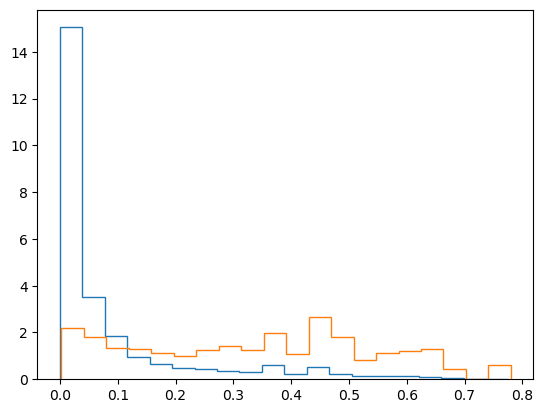

In [8]:
# BART: define and train model
if train_bart_model:
    weights  = np.ones((x_tr.shape[0],))   
    scale_pos_weight = np.sum(y_tr==0)/np.sum(y_tr==1)
    weights[y_tr==1] = scale_pos_weight
    print("scale weight:", scale_pos_weight)
    
    with pm.Model() as bart_model:
        X = pm.MutableData("X", x_tr, dims=("obs","feature"))
        Y = y_tr
        # the probability that a node at depth d (0,1,2,3...) is non-terminalis given by: alpha * ((1+d)^(-beta))
        # alpha=0.95, beta=2 is default. may want to tune hyperparameters?
        mu = pmb.BART("mu", X=X, Y=Y, m=n_trees, dims="obs", shape=X.shape[0], split_prior=BART_feature_priors) 
        p = pm.Deterministic('p', pm.math.invlogit(mu), dims="obs")
        #pm.Bernoulli("y", p=p, observed=Y, dims="obs",shape=p.shape[0])#shape=p.shape)
        
        pm.Potential('weights', 
             weights * pm.Bernoulli("y", p=p, observed=Y, dims="obs",shape=p.shape[0]))
        
        idata_train = pm.sample(tune=tune,draws=draws,chains=chains) # currently can't handle multiple chains, maybe fix?
        
        posterior_train = pm.sample_posterior_predictive(trace=idata_train,
                                                              var_names=["p"])
    
    prior_train = posterior_train.posterior_predictive.p.mean(axis=1).mean(axis=0).T

    plt.figure()
    plt.hist(prior_train[y_tr==0],histtype='step',bins=20,density=True);
    plt.hist(prior_train[y_tr==1],histtype='step',bins=20,density=True);

if save_bart_model:
    # extract trees in a nice structure....
    forests = []

    for i in range(len(pmb.BART.all_trees)):
        trees = []
        for j in range(len(pmb.BART.all_trees[i])):
            for k in range(pmb.BART.all_trees[i][j].shape[0]):
                trees.append(pmb.BART.all_trees[i][j][k])

        forests.append(trees)
    
    with open(tree_fname, 'wb') as f:
        pickle.dump({'forests':forests,'in_cols':in_cols},f)
else:
    with open(tree_fname,'rb') as f:
        forest_data = pickle.load(f)
    forests = forest_data['forests']

[[23924  4163]
 [  946  2054]]


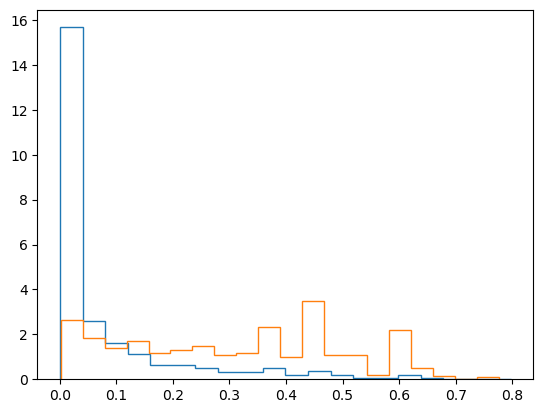

In [9]:
# BART test model
x_in = x_te
y_in = y_te

pred_per_forest = sample_posterior(forests,x_in)
pred_mean = np.mean(pred_per_forest,axis=1)

plt.figure()
plt.hist(pred_mean[y_in==0],histtype='step',bins=20,density=True);
plt.hist(pred_mean[y_in==1],histtype='step',bins=20,density=True);
print(confusion_matrix(y_true=y_te, y_pred=pred_mean>np.percentile(pred_mean,80)))

In [12]:
split_var_count = {}
for i in range(x_tr.shape[1]):
    split_var_count[i] = 0
    
for i in range(len(forests)):
    for j in range(len(forests[i])):
        for split_var in forests[i][j].get_split_variables():
            split_var_count[split_var] = split_var_count[split_var] + 1

for i in range(x_tr.shape[1]):
    print(in_cols[i],split_var_count[i])

result_PLHTN 469
result_IC__N 420
result_MRTYN 498
result_diff_EMRGR 522
result_diff_YGSMN 1814
result_diff_HLDGR 920
result_diff_HVAPR 270


[[24087  4000]
 [  782  2218]]


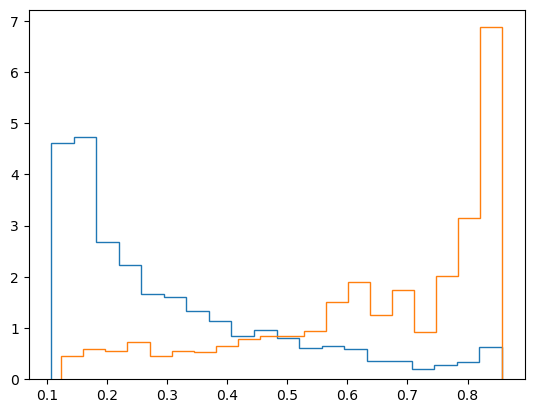

In [11]:
# xgboost (as a control):
# train xgb model
xgb_params = {'max_depth':5,
              'reg_lambda':100,
              'subsample':0.2,
              'learning_rate':0.005,
              'n_estimators':500,
             'scale_pos_weight':np.sum(y_tr==0)/np.sum(y_tr==1),
             'gamma':10,
             'booster':'gbtree'}

xgb_mdl = xgboost.XGBClassifier(**xgb_params)
xgb_mdl.fit(x_tr,y_tr)

# test xgb model
y_proba = xgb_mdl.predict_proba(x_te)[:,1]

plt.figure()
plt.hist(y_proba[y_te==0],bins=20,histtype='step',density=True)
plt.hist(y_proba[y_te==1],bins=20,histtype='step',density=True)

print(confusion_matrix(y_true=y_te, y_pred=y_proba>np.percentile(y_proba,80)))

In [ ]:
plt.plot(pred_mean, y_proba,'.')